# Import Libraries

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import re
import spacy
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Using TensorFlow backend.


# Download Spacy English Model

In [2]:
nlp = spacy.load('en', disable = ["parser", "ner", "textcat", "tagger"])

# Read Data

In [3]:
train = pd.read_csv("../input/cite-dataset/tsv/train.tsv", sep= '\t',names=["id", "explicit", "text", "label"])
dev = pd.read_csv("../input/cite-dataset/tsv/dev.tsv", sep= '\t', names=["id", "explicit", "text", "label"])
test = pd.read_csv("../input/cite-dataset/tsv/test.tsv", sep= '\t', names=["id", "explicit", "text", "label"])

# Drop Columns Not Used

In [4]:
train.drop(['id', 'explicit'], axis = 1, inplace = True)
test.drop(['id', 'explicit'], axis = 1, inplace = True)

# Convert String Label to Numeric Label

In [5]:
label_to_num = {"background":0, "method":1, "result":2}
def label_decoder(label):
    return label_to_num[label]

In [6]:
train["label1"] = train["label"].apply(lambda x: label_decoder(x))
train.head()

,text,label,label1
0,"However, how frataxin interacts with the Fe-S ...",background,0
1,"In the study by Hickey et al. (2012), spikes w...",background,0
2,"The drug also reduces catecholamine secretion,...",background,0
3,By clustering with lowly aggressive close kin ...,background,0
4,Ophthalmic symptoms are rare manifestations of...,background,0


In [7]:
test["label1"] = test["label"].apply(lambda x: label_decoder(x))
test.head()

,text,label,label1
0,"Chapel, as well as X10 [2], UPC [3] , CoArray ...",background,0
1,"In addition, the result of the present study s...",result,2
2,Several instruments that more specifically add...,background,0
3,Organotypic hippocampal slice cultures\nInterf...,method,1
4,Activated PBMC are the basis of the standard P...,background,0


# Preprocess Data

In [8]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [9]:
def preprocess(text, stem=False):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [10]:
train["text1"] = train["text"].apply(lambda x: preprocess(x))
test["text1"] = test["text"].apply(lambda x: preprocess(x))

# Length of Largest Sentence

In [11]:
MAX_SEQUENCE_LENGTH = 100

# Tokenize Sentences

In [12]:
tokens = []
for doc in tqdm(nlp.pipe(train["text1"].values, n_threads = 16)):
    tokens.append(" ".join([n.text for n in doc]))
train["text1"] = tokens

8243it [00:03, 2589.97it/s]


In [13]:
tokens = []
for doc in tqdm(nlp.pipe(test["text1"].values, n_threads = 16)):
    tokens.append(" ".join([n.text for n in doc]))
test["text1"] = tokens

1861it [00:00, 3005.68it/s]


# Split Data for Validation

In [14]:
train, val = train_test_split(train, test_size=0.1, random_state=2018)

# Initialize a Tokenizer

In [15]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\]^`{|}~')

tokenizer.fit_on_texts(train.text1)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 27579


# Pad Sentences to Length of Largest Sentence

In [16]:
x_train = pad_sequences(tokenizer.texts_to_sequences(train.text1),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_val = pad_sequences(tokenizer.texts_to_sequences(val.text1),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test.text1),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Validation X Shape:",x_val.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (7418, 100)
Validation X Shape: (825, 100)
Testing X Shape: (1861, 100)


# Vectorize the Labels

In [17]:
y_train = train['label1']
y_val = val["label1"]
y_test = test['label1']

In [18]:
y_train_list = []
for i in y_train:
    kd = np.zeros(3)
    kd[i]=1
    y_train_list.append(list(kd))

In [19]:
y_val_list = []
for i in y_val:
    kd = np.zeros(3)
    kd[i]=1
    y_val_list.append(list(kd))

In [20]:
y_test_list = []
for i in y_test:
    kd = np.zeros(3)
    kd[i]=1
    y_test_list.append(list(kd))

In [21]:
y_train_list = np.array(y_train_list)
y_val_list = np.array(y_val_list)
y_test_list = np.array(y_test_list)

# Download GloVE Model

In [22]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2022-07-31 18:50:50--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-07-31 18:50:51--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-07-31 18:50:51--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

# Conguration Values

In [23]:
GLOVE_EMB = '/kaggle/working/glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 50
MODEL_PATH = '.../output/kaggle/working/best_model.hdf5'

# Load GloVe Model

In [24]:
embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


# Generate Embedding Matrix from GloVe Model

In [25]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Embedding Layer to Vectorize Padded Sequences using Embedding Matrix

In [26]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

# LSTM Model

In [27]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2))(x)
outputs = Dense(3, activation='softmax')(x)
model = tf.keras.Model(sequence_input, outputs)


# Early Stopping Callback


In [28]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20, # Wait for next best value till 20 epochs
    verbose=1,
    mode='min',
    restore_best_weights=True
)

# Model Checkpointing Callback

In [29]:
mc = tf.keras.callbacks.ModelCheckpoint(
    "./model{epoch:04d}.h5",
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode="min",
    save_freq="epoch",
)

# Compile Model

In [30]:
model.compile(optimizer=Adam(learning_rate=LR), loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train Model

In [31]:
history = model.fit(x_train, y_train_list, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_val, y_val_list), callbacks=[es, mc])

Train on 7418 samples, validate on 825 samples
Epoch 1/50
7168/7418 [===========================>..] - ETA: 1s - loss: 1.0028 - accuracy: 0.5201
Epoch 00001: val_loss improved from inf to 1.02126, saving model to ./model0001.h5
7418/7418 [==============================] - 33s 4ms/sample - loss: 0.9988 - accuracy: 0.5233 - val_loss: 1.0213 - val_accuracy: 0.5467
Epoch 2/50
7168/7418 [===========================>..] - ETA: 0s - loss: 0.9067 - accuracy: 0.6124
Epoch 00002: val_loss improved from 1.02126 to 0.91461, saving model to ./model0002.h5
7418/7418 [==============================] - 24s 3ms/sample - loss: 0.9051 - accuracy: 0.6134 - val_loss: 0.9146 - val_accuracy: 0.6327
Epoch 3/50
7168/7418 [===========================>..] - ETA: 0s - loss: 0.8500 - accuracy: 0.6437
Epoch 00003: val_loss improved from 0.91461 to 0.85031, saving model to ./model0003.h5
7418/7418 [==============================] - 23s 3ms/sample - loss: 0.8478 - accuracy: 0.6445 - val_loss: 0.8503 - val_accuracy: 0

# Plot of the Training and Validation Metrics


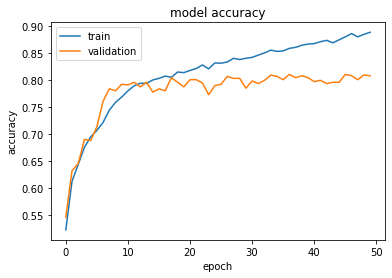

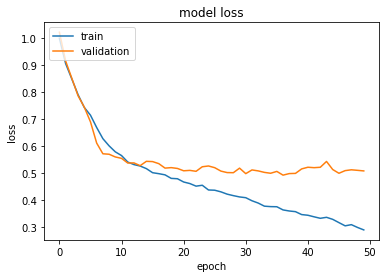

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Test Data Evaluation

In [33]:
test_acc = model.evaluate(x_test, y_test_list, verbose=0)
print("Test Loss:", test_acc[0])
print("Test Accuracy:", test_acc[1])

Test Loss: 0.589533142365159
Test Accuracy: 0.7839871


In [34]:
y_pred = model.predict(x_test, verbose=0)
yhat = np.argmax(y_pred,axis=1)
y_true = np.argmax(y_test_list,axis = 1)

In [35]:
accuracy_score(y_true,yhat)

0.783987103707684

In [36]:
precision_score(y_true,yhat, average='macro')

0.7574859860430241

In [37]:
recall_score(y_true,yhat, average='macro')

0.7754233076928436

In [38]:
f1_score(y_true,yhat, average='macro')

0.7653487433412055